<a href="https://colab.research.google.com/github/jyan83/Data_Challenges/blob/master/Breast%20Cancer%20Detection/Breast_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Breast Cancer Data Challenge

Time limit: 4 hours


## 1. Introduction
Machine Learning has been widly leveraged in the Breast cancer diagnosis. Here, University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg provided a dataset contains a series of features for each cell to diagnose *benign* and *malignant* cancer. The dataset contains the following 9 features for each cell:

* Clump Thickness: 1 - 10
* Uniformity of Cell Size: 1 - 10
* Uniformity of Cell Shape: 1 - 10
* Marginal Adhesion: 1 - 10
* Single Epithelial Cell Size: 1 - 10
* Bare Nuclei: 1 - 10
* Bland Chromatin: 1 - 10
* Normal Nucleoli: 1 - 10
* Mitoses: 1 - 10

The problem can be framed as: giving a list of features, can you diagnose if a patient has the cancer or not? This problem is treated as a binary classification problem.

Some other questions to be answered:
1. What features of a cell are the largest drivers of malignancy?
2. How would a physician use your product?
3. There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of
detecting malignancy?

## 2. EDA
### 2.1 Exploring Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
# import data
from google.colab import files
# uploaded = files.upload()

# !pip install docx2txt
import docx2txt
text = docx2txt.process("Copy of breast-cancer-wisconsin.docx")

# Tranfer docx to dataframe
from io import StringIO
mystr = StringIO(text)
df = pd.read_csv(mystr, index_col=0, header=0)

In [ ]:
# Print first 5 lines of altered dataset
df.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
0,1241035,7,8,3,7,4,5,7,8,2,4
1,1107684,6,10,5,5,4,10,6,10,1,4
2,691628,8,6,4,10,10,1,3,5,1,4
3,1226612,7,5,6,3,3,8,7,4,1,4
4,1142706,5,10,10,10,6,10,6,5,2,4


In [ ]:
# Details about the dataset
print(df.shape)
df.info()

(15855, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15855 entries, 0 to 15854
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           15855 non-null  int64 
 1   Clump Thickness              15855 non-null  int64 
 2   Uniformity of Cell Size      15827 non-null  object
 3   Uniformity of Cell Shape     15827 non-null  object
 4   Marginal Adhesion            15827 non-null  object
 5   Single Epithelial Cell Size  15827 non-null  object
 6   Bare Nuclei                  15827 non-null  object
 7   Bland Chromatin              15827 non-null  object
 8   Normal Nucleoli              15827 non-null  object
 9   Mitoses                      15827 non-null  object
 10  Class                        15827 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.5+ MB


1. There are missing values in this data set.
2. Attribute 2-9 are str, should convert to numerical numbers.

In [ ]:
# Change the str to numerical numbers & fill missing values with 0
for i in range(2,11):
  df.iloc[:,i] = pd.to_numeric(df.iloc[:,i], errors='coerce').fillna(0)

print(df['Class'].value_counts())
df.describe()

4.0     15164
2.0       456
40.0      151
0.0        79
20.0        5
Name: Class, dtype: int64


,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,1.585500e+04,15855.000000,15855.000000,15855.000000,15855.000000,15855.000000,15855.000000,15855.000000,15855.000000,15855.000000,15855.000000
mean,1.125972e+06,8.263198,7.438600,6.061053,5.461999,4.574898,6.962851,4.994387,5.379502,1.820246,4.270451
std,9.957879e+05,7.393603,6.804307,5.526014,6.106260,4.830904,7.057724,4.856984,5.872116,2.853623,3.542034
min,6.163400e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.076352e+06,7.000000,5.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,4.000000
50%,1.111249e+06,8.000000,6.000000,5.000000,4.000000,4.000000,8.000000,4.000000,5.000000,1.000000,4.000000
75%,1.198641e+06,10.000000,10.000000,7.000000,7.000000,4.000000,10.000000,7.000000,8.000000,2.000000,4.000000
max,1.345435e+07,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,70.000000,100.000000,70.000000,40.000000


1. Total number of data points present in each attribute is 15855.
2. The total numbers of data samples with different labels are not balanced.Cancer number is 456 out of 15855.
3. Skewed data.
4. In the class column, some 40.0 and 20.0 values should be typo, change to '2' and '4'. Also, the str '2' was mapped to 'Yes', which means the cancer is benign. And the value '4' was mapped to 'No', which means the cancer is malignant.

In [ ]:
df.loc[df.Class == 40] = 4.0
df.loc[df.Class == 20] = 2.0

print(df['Class'].value_counts())

# drop of the 79 non-categorized classes
df = df[df['Class'] > 0.0]


4.0    15315
2.0      461
0.0       79
Name: Class, dtype: int64


## 2.2 Visualize the dataset to gain some information:

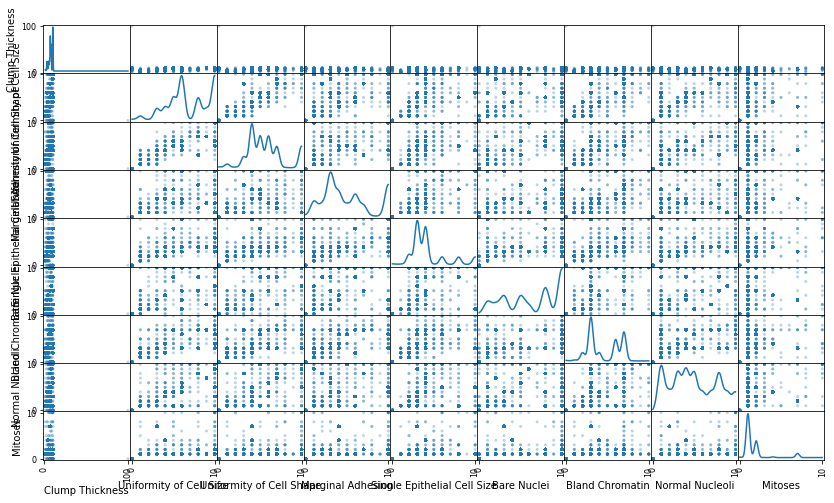

In [ ]:
# Create pair-plot to determine a possible relationship between the columns / attributes
diagnosis = df['Class']
features = df.drop(['ID', 'Class'], axis = 1)
pd.plotting.scatter_matrix(features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

As seen from the scatter plot matrix, these attributes are right skewed with a long tail. It means most of the statistical models are not able to work as most of them will be treated as an outlier. These datasets can be transformed using log transform, or using machine learning models.

First, deal with the skewness using Square Root Transformation:

In [ ]:
diagnosis = df['Class']
features = df.drop(['Class', 'ID'], axis = 1) 
sqrt_features = features.copy()
for feature_name in sqrt_features.columns:
    sqrt_features[feature_name] = np.log(sqrt_features[feature_name]) 
features = pd.DataFrame(sqrt_features)

# deal with inf
np.any(np.isinf(features))
np.any(np.isnan(features))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


False

## 3. Modeling

### 3.1 Prepare the training, testing data

In [ ]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, df['Class'], test_size=0.25, random_state=42)
# Scale the dataset
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
# deal with inf
np.any(np.isinf(X_train))
np.any(np.isnan(X_test))
X_train = X_train.replace([np.inf, -np.inf, np.isnan], 0.0)
X_test = X_test.replace([np.inf, -np.inf, np.isnan], 0.0)

# prepare target
from sklearn.preprocessing import LabelEncoder
def prepare_targets(y):
	le = LabelEncoder()
	le.fit(y)
	y = le.transform(y)
	return y

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
y_train = prepare_targets(y_train)
y_test = prepare_targets(y_test)


### 3.2 Spot-Checking Algorithms
First, select a series of classification model to do the classification, and compare the performance, using a k-fold validation and area under ROC to see the performance. 

Text(0.5, 1.0, 'testing')

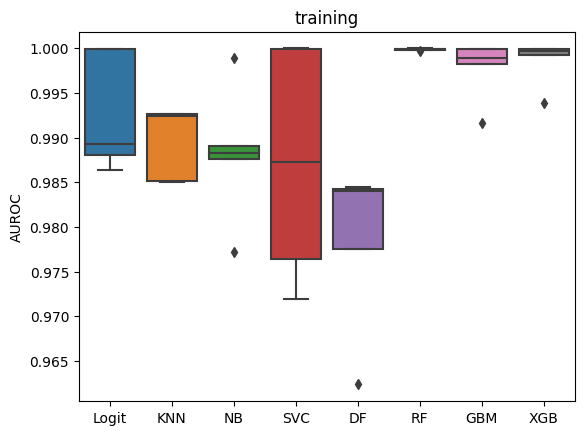

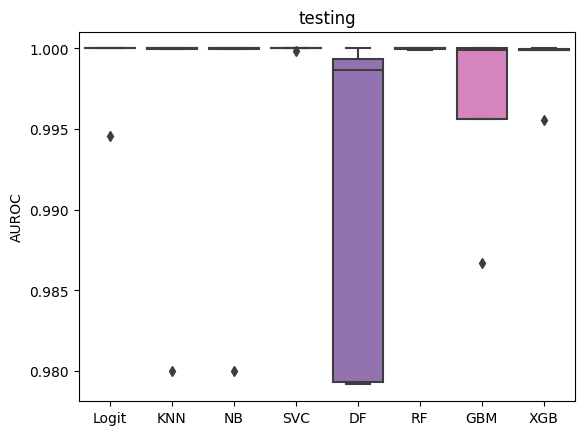

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score 
from sklearn.base import clone

clfs = [LogisticRegression(),
        KNeighborsClassifier(),
        GaussianNB(),
        SVC(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        xgb.XGBClassifier()]

clf_names = ['Logit',
             'KNN',
             'NB',
             'SVC',
             'DF',
             'RF',
             'GBM',
             'XGB']

# Stratified cross validation using 5 folds
cv = StratifiedKFold(n_splits=5,random_state=2,shuffle=True)

# Preset scores for all methods
all_scores_train = np.zeros((len(clf_names), cv.n_splits))
all_scores_test = np.zeros((len(clf_names), cv.n_splits))

for i in range(len(clfs)):
    clf = clone(clfs[i])
    scores_train = cross_val_score(clf, X_train, y_train,  cv=cv, scoring='roc_auc')
    all_scores_train[i] = scores_train
    scores_test = cross_val_score(clf, X_test, y_test,  cv=cv, scoring='roc_auc')
    all_scores_test[i] = scores_test
    
fig, ax = plt.subplots()
sns.boxplot(data=pd.DataFrame(all_scores_train.T, columns=clf_names), ax=ax)
ax.set_ylabel('AUROC')
ax.set_title('training')

fig, ax = plt.subplots()
sns.boxplot(data=pd.DataFrame(all_scores_test.T, columns=clf_names), ax=ax)
ax.set_ylabel('AUROC')
ax.set_title('testing')


It is seen from the classification models and we can see that Random Forest classification algorithm gives the best results and smallest standard deviation in both training and testing for our dataset. The area under roc has already close to 1, no more hyperparameter tunning is needed.

### 3.3 Explain Random Forest with feature importance

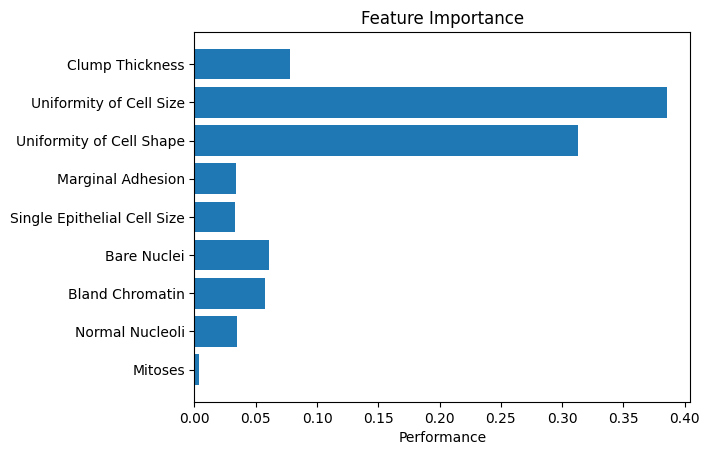

In [ ]:
rf = RandomForestClassifier()
model = rf.fit(X_train, y_train)

# feature importance
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(list(features.columns.values)))

ax.barh(y_pos, model.feature_importances_, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(list(features.columns.values))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Feature Importance')

plt.show()

## 4. Takeways


*   Uniformity of cell size and shape are the two most important features to diagnose a cancer
*   To use the cancer diagnose system, the physician should collect all the associated features as much as possible. 
*   If not possible to do all the test for the sake of money and time, the uniformity of cell size and shape should be tested at least, following by the clump thickness.

